In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
test_data_raw = np.loadtxt(open("../Datasets/mnist_test.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]
test_data = test_data_raw[:, 1:]
test_labels = test_data_raw[:, 0]

print(f"Train data shape: {train_data.shape, train_labels.shape}")
print(f"Test data shape: {test_data.shape, test_labels.shape}")

Train data shape: ((60000, 784), (60000,))
Test data shape: ((10000, 784), (10000,))


In [3]:
# Data normalization
train_data_norm = train_data / np.max(train_data)
test_data_norm = test_data / np.max(test_data)

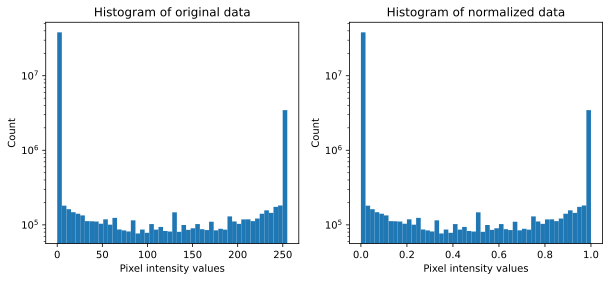

In [4]:
# Plot the data to see the data distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_data.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(train_data_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

plt.show()

In [5]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(train_data_norm).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_data_tensor = torch.tensor(test_data_norm).float()
test_labels_tensor = torch.tensor(test_labels).long()

# Test and dev set split
dev_dataset, test_dataset, dev_label, test_label = train_test_split(
    test_data_tensor, test_labels_tensor, test_size=0.5
)

# Convert into pytorch dataset
train_dataT = TensorDataset(train_data_tensor, train_labels_tensor)
dev_dataT = TensorDataset(dev_dataset, dev_label)
test_dataT = TensorDataset(test_dataset, test_label)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
devset_loader = DataLoader(
    dev_dataT,
    batch_size=dev_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)
testset_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [26]:
# Create the model function
def createNewMNISTNet(nUnits, nLayers, L2_lambda=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Create dictonary to store the layers
            self.layers = nn.ModuleDict()
            # Input Layer
            self.layers["input"] = nn.Linear(784, nUnits)

            # Hidden Layers
            for layer in range(nLayers):
                self.layers[f"hidden{layer}"] = nn.Linear(nUnits, nUnits)

            # Output Layer
            self.layers["output"] = nn.Linear(nUnits, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.layers["input"](x))

            for layer in range(nLayers):
                x = F.relu(self.layers[f"hidden{layer}"](x))

            return self.layers["output"](x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=L2_lambda)
    return net, lossFun, optimizer

In [27]:
# Test the model
net, lossFun, optimizer = createNewMNISTNet(16, 2)

X, y = next(iter(train_loader))
yHat = net(X)

loss = lossFun(yHat, y)
print(net)
print(f"Loss: {loss}")
print(yHat)

mnistNet(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=16, bias=True)
    (hidden0): Linear(in_features=16, out_features=16, bias=True)
    (hidden1): Linear(in_features=16, out_features=16, bias=True)
    (output): Linear(in_features=16, out_features=10, bias=True)
  )
)
Loss: 2.3280112743377686
tensor([[ 1.1648e-01, -1.0134e-01, -1.0937e-01,  2.6894e-03, -5.1493e-02,
         -1.9790e-01,  1.2344e-01,  2.4877e-01, -8.0055e-02,  1.0399e-01],
        [ 1.1874e-01, -1.0053e-01, -1.1142e-01,  4.3210e-03, -5.2565e-02,
         -1.9788e-01,  1.2454e-01,  2.4810e-01, -8.1625e-02,  1.0480e-01],
        [ 1.1810e-01, -1.0109e-01, -1.0578e-01,  6.8814e-04, -5.3749e-02,
         -1.9987e-01,  1.2354e-01,  2.4754e-01, -7.9165e-02,  1.0014e-01],
        [ 1.2166e-01, -1.0531e-01, -1.1353e-01,  1.9870e-03, -4.8976e-02,
         -1.8481e-01,  1.3037e-01,  2.3986e-01, -9.8302e-02,  1.0649e-01],
        [ 1.2014e-01, -1.0239e-01, -1.1036e-01,  2.1060e-03, -5.2905e-02,
   

In [28]:
# Function to train the model
nEpochs = 60


def trainTheModel(nUnits, nLayers, L2_lambda=0.01):
    net, lossFun, optimizer = createNewMNISTNet(nUnits, nLayers, L2_lambda)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    devAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = net(X)

        devAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu())
    # End of epoch

    return trainAcc, devAcc, losses, net

In [ ]:
# Function to check the test Accuracy
def testModePerformance(dataset):
    testAcc = []
    # Model in evaluation mode
    net.eval()

    for X, y in dataset:
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100 * (torch.argmax(yHat, axis=1) == y).float().cpu())

    return testAcc

In [19]:
# Run the Experiment, Takes more than 60 minutes to complete

# Define Model Parameters
nLayers = range(1, 4)
nUnits = np.arange(64, 288, 32)

# Initialize output matrics
accuracies = np.zeros((3, len(nUnits), len(nLayers)))
for unit_idx in range(len(nUnits)):
    for layer_idx in range(len(nLayers)):

        # Create and train a fress model
        trainAcc, devAcc, losses, net = trainTheModel(
            nUnits=nUnits[unit_idx], nLayers=nLayers[layer_idx]
        )

        # Test the model on test data
        testAcc = testModePerformance(testset_loader)
        # Store the results (average for last 10 epochs)
        accuracies[0, unit_idx, layer_idx] = np.mean(trainAcc[-10:])
        accuracies[1, unit_idx, layer_idx] = np.mean(devAcc[-10:])
        accuracies[2, unit_idx, layer_idx] = np.mean(testAcc)

        # print a friendly status message
        print(
            f"Finished units {unit_idx+1}/{len(nUnits)} and layers {layer_idx+1}/{len(nLayers)}"
        )
        print(f"Train Accuracy is : {np.mean(trainAcc[-10:])}")
        print(f"Dev Accuracy is : {np.mean(devAcc[-10:])}")
        print(f"Test Accuracy is : {np.mean(testAcc)}")

Finished units 1/7 and layers 1/3
Train Accuracy is : 99.42900085449219
Dev Accuracy is : 97.5219955444336
Test Accuracy is : 97.73999786376953
Finished units 1/7 and layers 2/3
Train Accuracy is : 99.8356704711914
Dev Accuracy is : 97.28199768066406
Test Accuracy is : 97.08000183105469
Finished units 1/7 and layers 3/3
Train Accuracy is : 99.94166564941406
Dev Accuracy is : 97.26199340820312
Test Accuracy is : 97.13999938964844
Finished units 2/7 and layers 1/3
Train Accuracy is : 99.67900085449219
Dev Accuracy is : 98.08399200439453
Test Accuracy is : 97.73999786376953
Finished units 2/7 and layers 2/3
Train Accuracy is : 99.96415710449219
Dev Accuracy is : 97.63200378417969
Test Accuracy is : 97.5199966430664
Finished units 2/7 and layers 3/3
Train Accuracy is : 99.99649810791016
Dev Accuracy is : 97.3060073852539
Test Accuracy is : 97.23999786376953
Finished units 3/7 and layers 1/3
Train Accuracy is : 99.7354965209961
Dev Accuracy is : 97.77999877929688
Test Accuracy is : 98.01999

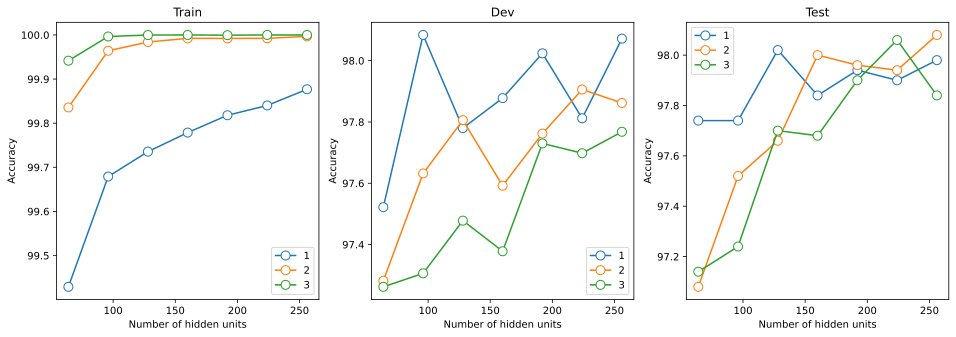

In [23]:
# Show the results
titles = ["Train", "Dev", "Test"]
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(nUnits, accuracies[0, :, :], "o-", markerfacecolor="w", markersize=9)
ax[1].plot(nUnits, accuracies[1, :, :], "o-", markerfacecolor="w", markersize=9)
ax[2].plot(nUnits, accuracies[2, :, :], "o-", markerfacecolor="w", markersize=9)

for i in range(3):
    ax[i].legend(nLayers)
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Number of hidden units")
    ax[i].set_title(titles[i])

In [29]:
# 1) Based on the results above, pick the best and the worst model architectures.
#    Then, run only those two models again using regularization (you can pick which
#    regularization method to use). Does this help the bad model and/or hurt the good model?

# => Worst Model has 64 nUnits and 1 layer, Best model has 256 nUnits and 3 Layers, also using L2 regularization with L2_lambda = 0.01
# Run the Experiment, Takes more than 60 minutes to complete

# Define Model Parameters
nLayers = [1, 3]
nUnits = [64, 256]

# Initialize output matrics
accuracies = np.zeros((3, len(nUnits), len(nLayers)))
for unit_idx in range(len(nUnits)):
    for layer_idx in range(len(nLayers)):

        # Create and train a fress model
        trainAcc, devAcc, losses, net = trainTheModel(
            nUnits=nUnits[unit_idx], nLayers=nLayers[layer_idx]
        )

        # Test the model on test data
        testAcc = testModePerformance(testset_loader)
        # Store the results (average for last 10 epochs)
        accuracies[0, unit_idx, layer_idx] = np.mean(trainAcc[-10:])
        accuracies[1, unit_idx, layer_idx] = np.mean(devAcc[-10:])
        accuracies[2, unit_idx, layer_idx] = np.mean(testAcc)

        # print a friendly status message
        print(
            f"Finished units {unit_idx+1}/{len(nUnits)} and layers {layer_idx+1}/{len(nLayers)}"
        )
        print(f"Train Accuracy is : {np.mean(trainAcc[-10:])}")
        print(f"Dev Accuracy is : {np.mean(devAcc[-10:])}")
        print(f"Test Accuracy is : {np.mean(testAcc)}")

Finished units 1/2 and layers 1/2
Train Accuracy is : 94.73049926757812
Dev Accuracy is : 95.01799011230469
Test Accuracy is : 94.5199966430664
Finished units 1/2 and layers 2/2
Train Accuracy is : 96.21067810058594
Dev Accuracy is : 95.5780029296875
Test Accuracy is : 95.58000183105469
Finished units 2/2 and layers 1/2
Train Accuracy is : 95.14500427246094
Dev Accuracy is : 95.45599365234375
Test Accuracy is : 94.66000366210938
Finished units 2/2 and layers 2/2
Train Accuracy is : 96.72816467285156
Dev Accuracy is : 96.31800079345703
Test Accuracy is : 96.4000015258789


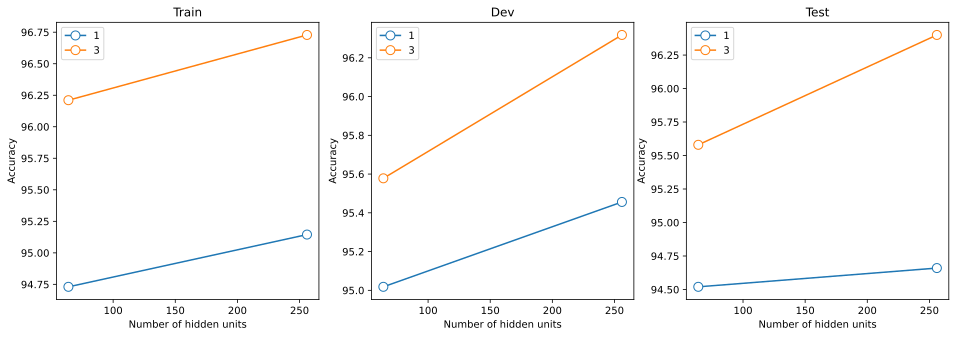

In [30]:
# Show the results
titles = ["Train", "Dev", "Test"]
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(nUnits, accuracies[0, :, :], "o-", markerfacecolor="w", markersize=9)
ax[1].plot(nUnits, accuracies[1, :, :], "o-", markerfacecolor="w", markersize=9)
ax[2].plot(nUnits, accuracies[2, :, :], "o-", markerfacecolor="w", markersize=9)

for i in range(3):
    ax[i].legend(nLayers)
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Number of hidden units")
    ax[i].set_title(titles[i])

In [ ]:
# 2) Time how long each model takes to train (from the full experiment, not just the two models
#    for exploration #1). Obviously, both factors (depth and breadth) affect training time, but
#    which factor seems to have a bigger influence on model training time?
# => Breadth takes more time than depth, but this experiment is going to take another 1.5 hrs of compute time so not doing it here, If you have
# Better hardware than me than feel free to try